In [188]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Fetching Data

In [198]:
data = pd.read_csv("test-data-iris.txt", delimiter=r"\s+", names = ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"])

In [199]:
print(data.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.7               4.4                1.5               0.4
1                5.5               4.2                1.4               0.2
2                5.2               4.1                1.5               0.1
3                5.8               4.0                1.2               0.2
4                5.4               3.9                1.7               0.4


# Plotting Data

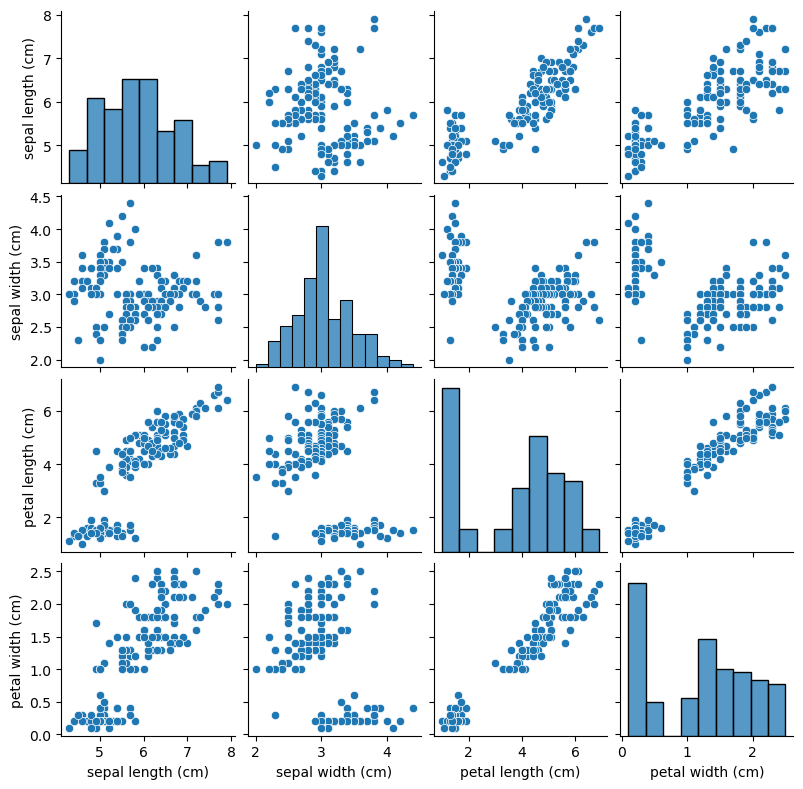

In [200]:
sns.pairplot(data, height=2)
plt.show()

In [201]:
data = data[['petal length (cm)', 'petal width (cm)']]
print(data.head())


   petal length (cm)  petal width (cm)
0                1.5               0.4
1                1.4               0.2
2                1.5               0.1
3                1.2               0.2
4                1.7               0.4


# Model

In [202]:
class Kmeans:
    def __init__(self, data, k, max_iterations = 500):
        
        """
        Initializes the KMeans clustering object.

        Args:
        - data: The input data for clustering
        - k: The number of clusters to form
        - max_iterations: Maximum number of iterations for convergence
        """
        
        self.k = k
        self.data = data
        self.max_iterations = max_iterations
        
    def select_random_centroids(self):
        
        """
        Selects k random data points as initial centroids.

        Returns:
        - centroids: DataFrame containing initial centroids
        """
        
        centroids = []
        for i in range(self.k):
            centroid = self.data.apply(lambda x: float(x.sample()))
            centroids.append(centroid)
        return pd.concat(centroids, axis=1)
    
    def euclidean_distance(self, point1, point2):
        
        """
        Calculates the Euclidean distance between two points.

        Args:
        - point1: First point
        - point2: Second point

        Returns:
        - distance: Euclidean distance between point1 and point2
        """
        
        return np.sqrt(((point1 - point2) ** 2).sum())

    def select_initial_centroids(self):
        
        """
        Selects initial centroids using KMeans++ algorithm.

        Returns:
        - initial_centroids: DataFrame containing initial centroids
        """
    
        centroids = [data.sample(random_state = 42).values[0]]

        for i in range(1, self.k):
            distances = np.array([min([self.euclidean_distance(np.array(x), np.array(c)) for c in centroids]) for x in self.data.values])

            distances = np.square(distances)
            probabilities = distances / distances.sum()

            
            new_centroid = data.sample(weights=probabilities).values[0]

            centroids.append(new_centroid)   
        return pd.DataFrame(centroids, columns=data.columns).T


    
    def get_clusters(self, centroids):
        
        """
        Assigns data points to the nearest cluster.

        Args:
        - centroids: DataFrame containing centroids

        Returns:
        - clusters: Series containing cluster assignments for each data point
        """
        
        distances = centroids.apply(lambda x: np.sqrt(((self.data -x)**2).sum(axis=1)))
        return distances.idxmin(axis=1)
    
    def calculate_new_centroids(self, clusters):
        
        """
        Calculates new centroids based on current cluster assignments.

        Args:
        - clusters: Series containing cluster assignments

        Returns:
        - new_centroids: DataFrame containing new centroids
        """
        
        new_centroids = data.groupby(clusters).apply(lambda x: np.mean(x)).T
        return new_centroids
    
    def sse(self, clusters, centroids):
        
        """
        Calculates Sum of Squared Errors (SSE) for clustering.

        Args:
        - clusters: Series containing cluster assignments
        - centroids: DataFrame containing centroids

        Returns:
        - sse: Sum of Squared Errors
        """
        
        errors = []
        print(centroids)
        for i in range(len(self.data.values)):

            centroid = centroids.iloc[clusters[i]]
            error =sum(np.array(self.data.values[i]) - np.array(centroid))**2
            errors.append(error**2)


        sse = sum(errors)

        return sse
    
    def find_clusters(self):
        
        """
        Performs KMeans clustering.

        Returns:
        - i: Number of iterations taken for convergence
        - clusters: Series containing final cluster assignments
        - centroids: DataFrame containing final centroids
        """
        
        centroids = self.select_random_centroids()
        previous_centroids = pd.DataFrame()
        i = -1
        sse = []
        while i < self.max_iterations and not centroids.equals(previous_centroids):
            previous_centroids = centroids
            clusters = self.get_clusters(previous_centroids)
            centroids = self.calculate_new_centroids(clusters)
            i+=1
        return i, clusters, centroids    
        

# Trying with various K- values (Elbow Method)

In [308]:
k_and_sse = {}
for i in range(2, 20, 2):
    kmeans = Kmeans(data, i)
    index, clusters, centroids = kmeans.find_clusters()
    print(type(clusters))
    k_and_sse[i] = kmeans.sse(clusters, centroids.T)

/Users/lokeshwaran/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/lokeshwaran/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/lokeshwaran/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=o

<class 'pandas.core.series.Series'>
   sepal length (cm)  petal width (cm)
0           6.412791          1.760465
1           5.078125          0.443750
<class 'pandas.core.series.Series'>
   sepal length (cm)  petal width (cm)
0           6.247059          1.727451
1           5.496154          1.215385
2           7.160870          2.082609
3           5.006000          0.244000
<class 'pandas.core.series.Series'>
   sepal length (cm)  petal width (cm)
0           6.166667          2.016667
1           5.709091          1.303030
2           7.180952          2.142857
3           5.206061          0.345455
4           6.531579          1.484211
5           4.670000          0.190000
<class 'pandas.core.series.Series'>
   sepal length (cm)  petal width (cm)
0           6.585000          2.205000
1           5.230000          0.280000
2           7.475000          2.050000
3           5.016667          1.200000
4           5.640000          1.220000
5           5.937500          1.80000

/Users/lokeshwaran/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/lokeshwaran/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/lokeshwaran/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=o

In [309]:
print(k_and_sse)

{2: 121.66438223459593, 4: 9.001358788143811, 6: 3.670454117435736, 8: 1.8816879267361157, 10: 1.9432464158708203, 12: 0.8490221831048553, 14: 0.365865589026626, 16: 0.4475387611505022, 18: 0.6862418599786005}


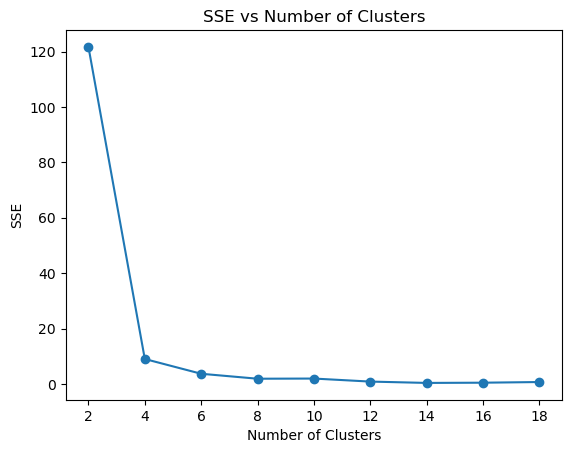

In [310]:
plt.plot(list(k_and_sse.keys()), list(k_and_sse.values()), marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('SSE vs Number of Clusters')
plt.show()

# For K-value = 3

In [194]:
kmeans = Kmeans(data, 3)
index, clusters, centroids = kmeans.find_clusters()

/Users/lokeshwaran/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/lokeshwaran/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/lokeshwaran/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=o

In [195]:
print(clusters.value_counts())
print(len(clusters))
print(index)

1    52
2    50
0    48
dtype: int64
150
4


In [196]:
filename = 'format-file-iris.txt'
with open(filename, 'w') as file:
    for i in range(len(clusters)):
        file.write(str(clusters[i] + 1) + '\n')